In [13]:
# Load environment variables from parent directory and set up auto-reload
import os
from dotenv import load_dotenv
load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Planning: TODO Lists

Many agents use TODO lists as a critical navigation tool for steering through long-running, complex tasks. Claude Code leverages [plan mode](https://www.anthropic.com/engineering/claude-code-best-practices) to create structured TODO lists before executing tasks, utilizing a specific tool called `TodoWrite` based on the [Claude Code prompt](https://cchistory.mariozechner.at/). Each TODO item contains three key components: content (a short, specific task description), status (pending, in_progress, or completed), and a unique identifier for tracking progress.

The challenge with TODO lists lies in maintaining attention as context windows grow—the average Manus task uses approximately 50 tool calls, creating substantial risk of [context rot](https://research.trychroma.com/context-rot). Agents become vulnerable to drifting off-topic or forgetting earlier objectives during lengthy conversations or complicated tasks. By continuously rewriting and updating the TODO list, agents like Manus effectively recite their objectives at the end of the context, helping to [stay focused on task](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus) and prevent mission drift.

### State

**TODO(Geoff)** Can explain here that we define the state object 
* Explain `AgentState` (`langgraph.prebuilt.chat_agent_executor import AgentState`)
* Explain with `todo` we will simple overwrite the state with each tools call. 
* Explain `files` and `file_reducer`. 

In [14]:
%%writefile ../src/deep_agents_from_scratch/state.py

from typing import NotRequired, Annotated, TypedDict, Literal
from langgraph.prebuilt.chat_agent_executor import AgentState

class Todo(TypedDict):
    """A structured task item for tracking progress through complex workflows.
    
    Attributes:
        content: Short, specific description of the task
        status: Current state - pending, in_progress, or completed
    """
    content: str
    status: Literal["pending", "in_progress", "completed"]

def file_reducer(l, r):
    """Merge two file dictionaries, with right side taking precedence.
    
    Used as a reducer function for the files field in agent state,
    allowing incremental updates to the virtual file system.
    
    Args:
        l: Left side dictionary (existing files)
        r: Right side dictionary (new/updated files)
        
    Returns:
        Merged dictionary with r values overriding l values
    """
    if l is None:
        return r
    elif r is None:
        return l
    else:
        return {**l, **r}

class DeepAgentState(AgentState):
    """Extended agent state that includes task tracking and virtual file system.
    
    Inherits from LangGraph's AgentState and adds:
    - todos: List of Todo items for task planning and progress tracking
    - files: Virtual file system stored as dict mapping filenames to content
    """
    todos: NotRequired[list[Todo]]
    files: Annotated[NotRequired[dict[str, str]], file_reducer]

Overwriting ../src/deep_agents_from_scratch/state.py


### Tool Description  

**TODO(Geoff)** Here we can explain how the tool will be used


In [15]:
from utils import show_prompt
from deep_agents_from_scratch.prompts import WRITE_TODOS_DESCRIPTION

show_prompt(WRITE_TODOS_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  When to Use:                                                                                                   │
│  - Use for multi-step or non-trivial tasks.                                                                     │
│  - Create when the user gives multiple tasks, or explicitly asks for a todo list.                               │
│  - Avoid for single, trivial actions.                                                                           │
│                                                                                                                 │
│  How to Structure:                                                                                              │
│  - Keep one list containing multiple todo objects (content, status, id).                                        │
│  - Use clear, actionable content text.                                                                          │
│  - Status must be pending, in_progress, or completed.                                                           │
│                                                                                                                 │
│  Best Practices:                                                                                                │
│  - Only one in_progress task at a time.                                                                         │
│  - Mark completed as soon as the task is fully done.                                                            │
│  - Always send the full updated list when making changes.                                                       │
│  - Prune irrelevant items to keep the list short and focused.                                                   │
│                                                                                                                 │
│  Progress Updates:                                                                                              │
│  - Call TodoWrite again to change a task’s status or edit its text.                                             │
│  - Reflect real-time progress; don’t batch completions.                                                         │
│  - If blocked, keep in_progress and add a new task describing the blocker.                                      │
│                                                                                                                 │
│  Args:                                                                                                          │
│      TODOs: List of TODO items with content and status fields                                                   │
│                                                                                                                 │
│  Returns:                                                                                                       │
│      Adds TODOs to the agent state.                                                                             │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

### Write and Read ToDo Tools 

**TODO(Geoff)** 
* Carefully explain what is happening when return `Command` type from a tool call. 
* We are using this to update the graph state! 
* Normally, from a tool call we just return a string.
* This will be packaged as a `ToolMessage` and added to `messages` key.
* This is done w/ `create_react_agent` prebuilt. 
* `Command` is executed by the graph and a tool can update various keys in graph state. 

For the read tool, we can just return a string. 
* This takes advantage of LangGraph persistence! 
* We can always get TODOs from state. 
* This ensures the agent does not loose track of them! 

In [16]:
%%writefile ../src/deep_agents_from_scratch/todo_tool.py

from typing import Annotated
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command

from deep_agents_from_scratch.prompts import WRITE_TODOS_DESCRIPTION
from deep_agents_from_scratch.state import DeepAgentState, Todo

@tool(description=WRITE_TODOS_DESCRIPTION)
def write_todos(
    todos: list[Todo], 
    tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    return Command(
        update={
            "todos": todos,
            "messages": [
                ToolMessage(f"Updated todo list to {todos}", tool_call_id=tool_call_id)
            ],
        }
    )

@tool(parse_docstring=True)
def read_todos(
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Read the current TODO list from the agent state.
    
    This tool allows the agent to retrieve and review the current TODO list
    to stay focused on remaining tasks and track progress through complex workflows.
    
    Args:
        state: Injected agent state containing the current TODO list
        tool_call_id: Injected tool call identifier for message tracking
     
    Returns:
        Formatted string representation of the current TODO list
    """
    todos = state.get('todos', [])
    if not todos:
        return "No todos currently in the list."
    
    result = "Current TODO List:\n"
    for i, todo in enumerate(todos, 1):
        status_emoji = {"pending": "⏳", "in_progress": "🔄", "completed": "✅"}
        emoji = status_emoji.get(todo['status'], "❓")
        result += f"{i}. {emoji} {todo['content']} ({todo['status']})\n"
    
    return result.strip()
    

Overwriting ../src/deep_agents_from_scratch/todo_tool.py


### Graph  

**TODO(Geoff)** 
* Here we can explain create_react_agent.
* Explain how it uses `state_schema` to define the state of the agent.
* Let's just focus on getting an agent to use the write and read TODOs tool clearly.
* We'll follow Manus's approach to TODO recitation after each task.
* We'll use a list of TODOs written as tool calls, similar to Claude Code.

In [17]:
from deep_agents_from_scratch.prompts import TODO_USAGE_INSTRUCTIONS

show_prompt(TODO_USAGE_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  Based upon the user's request:                                                                                 │
│  1. Use the write_todos tool to create TODO at the start of a user request, per the tool description.           │
│  2. After you accomplish a TODO, use the read_todos to read the TODOs in order to remind yourself of the plan.  │
│  3. Reflect on what you've done and the TODO.                                                                   │
│  4. Mark you task as completed, and proceed to the next TODO.                                                   │
│  5. Continue this process until you have completed all TODOs.                                                   │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

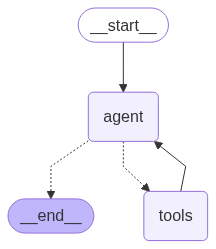

In [21]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from tavily import TavilyClient

from deep_agents_from_scratch.state import DeepAgentState
from deep_agents_from_scratch.todo_tool import write_todos, read_todos
from utils import format_messages

@tool(parse_docstring=True)
def web_search(
    query: str,
):
    """Search the web for information on a specific topic.
    
    This tool uses Tavily to perform web searches and returns relevant results
    for the given query. Use this when you need to gather information from
    the internet about any topic.
    
    Args:
        query: The search query string. Be specific and clear about what 
               information you're looking for.
    
    Returns:
        Search results from Tavily including titles, URLs, and content snippets
        from relevant web pages.
        
    Example:
        web_search("machine learning applications in healthcare")
    """
    tavily_client = TavilyClient()
    search_results = tavily_client.search(
        query,
        max_results=5,
        include_raw_content=False,
        topic="general",
    )
    return search_results

# Create agent using create_react_agent directly
model = init_chat_model(model="anthropic:claude-sonnet-4-20250514", temperature=0.0)
tools = [write_todos, web_search, read_todos]

# Create agent with system prompt
agent = create_react_agent(model, tools, prompt=TODO_USAGE_INSTRUCTIONS+"\n\n"+"Use web_search to find information.", state_schema=DeepAgentState)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

Start the graph with no `todos` in state and an user research request. 

In [23]:
# Example usage
result = agent.invoke({
    "messages": [{"role": "user", "content": "Give me an overview of Model Context Protocol (MCP)."}],
    "todos": []
})

format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you get an overview of Model Context Protocol (MCP). Let me start by creating a TODO list and then    │
│ searching for information about it.                                                                             │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Search for information about Model Context Protocol (MCP)",                                   │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Analyze and summarize key aspects of MCP",                                                    │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Provide comprehensive overview to user",                                                      │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_016TMhinZrvWNxY2JsUTCEZX                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Search for information about Model Context Protocol (MCP)', 'status':        │
│ 'pending'}, {'content': 'Analyze and summarize key aspects of MCP', 'status': 'pending'}, {'content': 'Provide  │
│ comprehensive overview to user', 'status': 'pending'}]                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now let me search for information about Model Context Protocol (MCP).                                           │
│                                                                                                                 │
│ 🔧 Tool Call: web_search                                                                                        │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol MCP overview what is it"                                                     │
│ }                                                                                                               │
│    ID: toolu_01L9UmQZXC6ZebJ2XomCVyGr                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {"query": "Model Context Protocol MCP overview what is it", "follow_up_questions": null, "answer": null,        │
│ "images": [], "results": [{"url": "https://en.wikipedia.org/wiki/Model_Context_Protocol", "title": "Model       │
│ Context Protocol", "content": "The **Model Context Protocol** (**MCP**) is an open standard,                    │
│ open-sourceframework introduced by Anthropic in November 2024 to standardize the way artificial intelligence    │
│ (AI) systems like large language models (LLMs) integrate and share data with external tools, systems, and data  │
│ sources. The protocol was announced by Anthropic in November 2024 as an open standard for connecting AI         │
│ assistants to data systems such as content repositories, business management tools, and development             │
│ environments. Demis Hassabis, CEO of Google DeepMind, confirmed in April 2025 MCP support in the upcoming       │
│ Gemini \"Gemini (chatbot)\") models and related infrastructure, describing the protocol as \"rapidly becoming   │
│ an open standard for the AI agentic era\".", "score": 0.918838, "raw_content": null}, {"url":                   │
│ "https://www.reddit.com/r/LLMDevs/comments/1jbqegg/model_context_protocol_mcp_clearly_explained/", "title":     │
│ "Model Context Protocol (MCP) Clearly Explained : r/LLMDevs", "content": "The Model Context Protocol (MCP) is a │
│ standardized protocol that connects AI agents to various external tools and data sources.", "score": 0.8858788, │
│ "raw_content": null}, {"url":                                                                                   │
│ "https://www.forbes.com/sites/davidbirch/2025/04/26/why-you-need-to-know-about-the-model-context-protocol/",    │
│ "title": "Why You Need To Know About The Model Context Protocol", "content": "The Model Context Protocol (MCP)  │
│ is an open standard that enables developers to build secure, two-way connections between their data sources and │
│ AI-powered", "score": 0.88444936, "raw_content": null}, {"url":                                                 │
│ "https://www.ibm.com/think/topics/model-context-protocol", "title": "What is Model Context Protocol (MCP)?",    │
│ "content": "The Model Context Protocol (MCP) serves as a standardization layer for AI applications to           │
│ communicate effectively with external services such as tools, databases and predefined templates. MCP allows AI │
│ agents to be context-aware while complying with a standardized protocol for tool integration. Regardless, the   │
│ need for standardized tool integration is critical for AI agents to operate autonomously and adapt dynamically  │
│ to real-world environments.10 With MCP, we can streamline the automation of complex agentic workflows to allow  │
│ for less human oversight.In turn, this shift enabled by MCP allows our time to be spent on more nuanced tasks   │
│ requiring human intellect and intuition.", "score": 0.8810534, "raw_content": null}, {"url":                    │
│ "https://www.anthropic.com/news/model-context-protocol", "title": "Introducing the Model Context Protocol",     │
│ "content": "*   Claude Today, we're open-sourcing the Model Context Protocol (MCP), a new standard for          │
│ connecting AI assistants to the systems where data lives, including content repositories, business tools, and   │
│ development environments. The Model Context Protocol is an open standard that enables developers to build       │
│ secure, two-way connections between their data sources and AI-powered tools. Claude 3.5 Sonnet is adept at      │
│ quickly building MCP server implementations, making it easy for organizations and individuals to rapidly        │
│ connect their most important datasets with a range of AI-powered tools. All Claude.ai plans support connecting  │
│ MCP servers to the Claude Desktop app.", "score": 0.868

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_todos                                                                                        │
│    Args: {}                                                                                                     │
│    ID: toolu_01W3T5uudCBzsMJkGzytpBvT                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Current TODO List:                                                                                              │
│ 1. ⏳ Search for information about Model Context Protocol (MCP) (pending)                                       │
│ 2. ⏳ Analyze and summarize key aspects of MCP (pending)                                                        │
│ 3. ⏳ Provide comprehensive overview to user (pending)                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Great! I've found good information about MCP. Let me mark the first task as completed and move to analyzing the │
│ information.                                                                                                    │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Search for information about Model Context Protocol (MCP)",                                   │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Analyze and summarize key aspects of MCP",                                                    │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Provide comprehensive overview to user",                                                      │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_011NGW4mLLu53w9DuDzUib4s                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Search for information about Model Context Protocol (MCP)', 'status':        │
│ 'completed'}, {'content': 'Analyze and summarize key aspects of MCP', 'status': 'in_progress'}, {'content':     │
│ 'Provide comprehensive overview to user', 'status': 'pending'}]                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Let me search for more technical details about MCP to provide a more comprehensive overview.                    │
│                                                                                                                 │
│ 🔧 Tool Call: web_search                                                                                        │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol MCP technical specifications features benefits"                              │
│ }                                                                                                               │
│    ID: toolu_01Hn2yzbXoZJxckAE5Vccb6R                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {"query": "Model Context Protocol MCP technical specifications features benefits", "follow_up_questions": null, │
│ "answer": null, "images": [], "results": [{"url": "https://modelcontextprotocol.io/specification/2025-06-18",   │
│ "title": "Specification - Model Context Protocol", "content": "Model Context Protocol (MCP) is an open protocol │
│ that enables seamless integration between LLM applications and external data sources and tools. Whether you’re  │
│ building an AI-powered IDE, enhancing a chat interface, or creating custom AI workflows, MCP provides a         │
│ standardized way to connect LLMs with the context they need.This specification defines the authoritative        │
│ protocol requirements, based on the TypeScript schema in schema.ts.For implementation guides and examples,      │
│ visit modelcontextprotocol.io.The key words “MUST”, “MUST NOT”, “REQUIRED”, “SHALL”, “SHALL NOT”, “SHOULD”,     │
│ “SHOULD NOT”, “RECOMMENDED”, “NOT RECOMMENDED”, “MAY”, and “OPTIONAL” in this document are to be interpreted as │
│ described in BCP 14 [RFC2119] [RFC8174] when, and only when, they appear in all capitals, as shown here. *      │
│ Hosts must obtain explicit user consent before exposing user data to servers", "score": 0.8479807,              │
│ "raw_content": null}, {"url":                                                                                   │
│ "https://www.moveworks.com/us/en/resources/blog/model-context-protocol-mcp-explained", "title": "Understanding  │
│ the Power of Model Context Protocol (MCP)", "content": "Simplifying AI Connections: Understanding the Power of  │
│ Model Context Protocol (MCP) | Moveworks When an enterprise can set up a robust, enterprise-ready foundation    │
│ for MCP, it can help to make smoother integrations possible for developers, whether you need AI to chat with    │
│ another app, access a database, or easily interact with customer service platforms, MCP benefits organizations  │
│ with AI tools by providing a standardized framework that ensures seamless integration and interoperability      │
│ between various AI models and applications to help reduce complexity. Open source Model Context Protocol (MCP)  │
│ serversfacilitate the smooth integration of AI agents and models with various tools, data sources, and          │
│ services. Without a standard like MCP, developers must coordinate with every single AI provider to align on an  │
│ integration setup that works.", "score": 0.78709817, "raw_content": null}, {"url":                              │
│ "https://treblle.com/blog/model-context-protocol-guide", "title": "What is the Model Context Protocol (MCP)? A  │
│ Complete Guide", "content": "Model Context Protocol (MCP) simplifies this by standardizing how models interact  │
│ with tools. MCP standardizes communication between models and APIs, reducing the need for custom integrations   │
│ and simplifying context management. The Model Context Protocol (MCP) is an open standard developed by Anthropic │
│ to simplify how models interact with various data sources and tools. Unlike traditional API integrations, which │
│ require custom, often rigid, connections for each tool, MCP provides a unified framework that standardizes      │
│ communication. *   **Standardized Communication:** MCP replaces the need for custom API connectors with a       │
│ consistent protocol, allowing models to access external tools uniformly. By standardizing how models            │
│ communicate with various tools and services, MCP reduces development overhead and ensures consistency across    │
│ integrations.", "score": 0.76701033, "raw_content": null}, {"url":                                              │
│ "https://stytch.com/blog/model-context-protocol-introduction/", "title": "Model Context Protocol (MCP): A       │
│ comprehensive introduction for ...", "content": "This a

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_todos                                                                                        │
│    Args: {}                                                                                                     │
│    ID: toolu_01HvRTdvqkQDmm3S9ZVXBxUG                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Current TODO List:                                                                                              │
│ 1. ✅ Search for information about Model Context Protocol (MCP) (completed)                                     │
│ 2. 🔄 Analyze and summarize key aspects of MCP (in_progress)                                                    │
│ 3. ⏳ Provide comprehensive overview to user (pending)                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Perfect! Now I have comprehensive information about MCP. Let me complete the analysis and move to providing the │
│ overview.                                                                                                       │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Search for information about Model Context Protocol (MCP)",                                   │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Analyze and summarize key aspects of MCP",                                                    │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Provide comprehensive overview to user",                                                      │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_019WvhDegVme68r6Tze9HHBE                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Search for information about Model Context Protocol (MCP)', 'status':        │
│ 'completed'}, {'content': 'Analyze and summarize key aspects of MCP', 'status': 'completed'}, {'content':       │
│ 'Provide comprehensive overview to user', 'status': 'in_progress'}]                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ # Model Context Protocol (MCP) - Comprehensive Overview                                                         │
│                                                                                                                 │
│ ## What is MCP?                                                                                                 │
│                                                                                                                 │
│ The **Model Context Protocol (MCP)** is an open-source standard introduced by Anthropic in November 2024 that   │
│ standardizes how AI systems, particularly Large Language Models (LLMs), integrate and share data with external  │
│ tools, systems, and data sources. It's rapidly becoming recognized as a foundational protocol for the AI        │
│ agentic era.                                                                                                    │
│                                                                                                                 │
│ ## Key Features & Benefits                                                                                      │
│                                                                                                                 │
│ ### 🔗 **Standardized Integration**                                                                             │
│ - **Unified Framework**: Replaces the need for custom API connectors with a consistent protocol                 │
│ - **Universal Communication**: Enables AI models to access external tools uniformly                             │
│ - **Reduced Complexity**: Eliminates the need for developers to coordinate with every AI provider individually  │
│                                                                                                                 │
│ ### 🛡️ **Security & Control**                                                                                    │
│ - **Secure Connections**: Enables secure, two-way connections between data sources and AI tools                 │
│ - **User Consent**: Requires explicit user consent before exposing user data to servers                         │
│ - **Enterprise-Ready**: Designed with enterprise security considerations in mind                                │
│                                                                                                                 │
│ ### ⚡ **Enhanced AI Capabilities**                                                                             │
│ - **Context-Aware AI**: Allows AI agents to be context-aware while maintaining standardized protocols           │
│ - **Real-Time Data Access**: Provides AI models with access to relevant data sources in real-time               │
│ - **Autonomous Operation**: Enables AI agents to operate more autonomously with less human oversight            │
│                                                                                                                 │
│ ## Technical Architecture                                                                                       │
│                                                                                                                 │
│ ### **Client-Server Model**                                                                                     │
│ - **MCP Clients**: AI applications that consume data and tools                                                  │
│ - **MCP Servers**: Services that provide data sources, tools, and capabilities                                  │
│ - **Standardized Communication**: Both sides communicate using the MCP protocol specification                   │
│                                                                                                                 │
│ ### **Core Components**                                 

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Search for information about Model Context Protocol (MCP)', 'status':        │
│ 'completed'}, {'content': 'Analyze and summarize key aspects of MCP', 'status': 'completed'}, {'content':       │
│ 'Provide comprehensive overview to user', 'status': 'completed'}]                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I've provided you with a comprehensive overview of the Model Context Protocol (MCP). This emerging standard is  │
│ positioning itself as a crucial infrastructure component for AI applications, similar to how HTTP became        │
│ fundamental for web applications. The protocol addresses a real need in the AI ecosystem by standardizing how   │
│ AI models interact with external data and tools, which should significantly simplify development and improve    │
│ interoperability across different AI systems.                                                                   │
│                                                                                                                 │
│ Is there any specific aspect of MCP you'd like me to explore further, such as implementation details, specific  │
│ use cases, or comparison with other integration approaches?                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯